# Week 5: Neural Network

### What's on this week
1. [Resuming from week 4](#resume)
2. [Building your first neural network model](#build)
3. [Understanding your neural network model](#viz)
4. [Finding optimal hyperparameters with GridSearchCV](#gridsearch)
5. [Feature selection](#fselect)
6. [Comparing each model](#comparison)

---

### Important Changelog:
* (25/07/2017) Made tutorial notes public.
* (28/08/2017) Finally bringing myself to finish the explanation. Sorry guys :)

The practical note for this week introduces you to neural network mining in Python, particularly using multilayer perceptron classifier. Neural networks are a class of predictive models that mimic the structure of human brain. It consists of layers of neurons, each consuming outputs from the previous layers as inputs. Neural network is the most complex model out of everything that we have used so far.

**This tutorial notes is in experimental version. Please give us feedbacks and suggestions on how to make it better. Ask your tutor for any question and clarification.**

## 1. Resuming from week 4<a name="resume"></a>
Last week, we learned how to perform data mining with decision trees in Python. For this week, we will again reuse the code for data preprocessing. Just as regression models, neural networks are sensitive to skewed data, thus we also need to perform standarization on the dataset:

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from dm_tools import data_prep
from sklearn.preprocessing import StandardScaler

# preprocessing step
df = data_prep()

# train test split
y = df['TargetB']
X = df.drop(['TargetB'], axis=1)
X_mat = X.as_matrix()
X_train, X_test, y_train, y_test = train_test_split(X_mat, y, test_size=0.33, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train, y_train)
X_test = scaler.transform(X_test)

## 2. Building your first neural network model

Start by importing your neural network from the library. As mentioned in the previous weeks, our aim is to classify people on this dataset into donors and non-donors. In `sklearn`, one neural network designed for that purpose is `MLPClassifier`, short of multi-layer perceptron classifier.

In [2]:
from sklearn.neural_network import MLPClassifier

Let's train our first MLPClassifier. Initiate the model without any additional parameter and see how it performs.

In [3]:
model = MLPClassifier()
model.fit(X_train, y_train)

print("Train accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

print(model)

Train accuracy: 0.933718769358
Test accuracy: 0.53128226306
             precision    recall  f1-score   support

          0       0.53      0.53      0.53      2422
          1       0.53      0.54      0.53      2421

avg / total       0.53      0.53      0.53      4843

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)


C:\Users\lieh\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


Our first neural network did pretty okay, with 0.535 accuracy score on the test data. You should notice that the training accuracy is much higher than the test accuracy. This is again an indication of overfitting, which we will fix in the next steps.

In addition, we got a "convergence is not reached" warning message from the neural network. Just as regression, neural networks compute values/predict using activation function with input weights in each neuron. These weights are learned in an iterative  process called "backpropagation" and in `MLPClassifier` the number of iteration is limited by `max_iter` parameter (default 200). The warning message basically tell us that the `max_iter` value is not enough to finish the backpropagation process, which we have to increase the number of max iterations.

Try to increase the `max_iter` to 500 from the original 200.

In [4]:
model = MLPClassifier(max_iter=500)
model.fit(X_train, y_train)

print("Train accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

print(model)

Train accuracy: 0.973363617592
Test accuracy: 0.529836877968
             precision    recall  f1-score   support

          0       0.53      0.53      0.53      2422
          1       0.53      0.53      0.53      2421

avg / total       0.53      0.53      0.53      4843

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)


With 500 max iterations, we managed to reach convergence. Let's keep this value. You can set up the max iter value higher to guarantee convergence everytime, at cost of slower training process.

## 4. Finding optimal hyperparameter with GridSearchCV

Once we have trained our first neural network, we should tune it to increase its performance using GridSearchCV. Neural network is one of the hardest models to tune due to its relatively high number of parameters and slow training process. For this tutorial, let's focus on tuning two parameters:
1. `hidden_layer_sizes`: It has values of tuples, and within each tuple, element i-th represent the number of neurons contained in each hidden layer.
2. `alpha`: L2 regularization parameter used in each neuron's activation function.

Firstly, let's start by tuning the hidden layer sizes. There is no official guideline on how many neurons we should have in each layer, but for most cases it is sufficient to have a single hidden layer with neurons count between `number of features` (input variables) and `output neurons` (in this case, it is 2).

**Fun Fact:** You might have heard of deep learning, which is a process of building very complex neural networks (these models often have hundreds of layers and thousands of neurons, hence **deep**). They are typically used for high level tasks, like image recognition, Siri-like voice assistant, machine translation and beating Go world champion. You might contribute in building the next Skynet here... :)

Let's see how many input features we have.

In [5]:
print(X_train.shape)

(4843, 85)


With 85 features, we will start tuning with one hidden layer of 5 to 85 neurons, increment of 25. (This is going to be slow).

In [6]:
params = {'hidden_layer_sizes': [(x,) for x in range(5, 86, 25)]}

cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(max_iter=500), cv=10, n_jobs=-1)
cv.fit(X_train, y_train)

print("Train accuracy:", cv.score(X_train, y_train))
print("Test accuracy:", cv.score(X_test, y_test))

y_pred = cv.predict(X_test)
print(classification_report(y_test, y_pred))

print(cv.best_params_)

Train accuracy: 0.636795374768
Test accuracy: 0.549039851332
             precision    recall  f1-score   support

          0       0.55      0.56      0.56      2422
          1       0.55      0.53      0.54      2421

avg / total       0.55      0.55      0.55      4843

{'hidden_layer_sizes': (5,)}


Our GridSearchCV returns 5 neurons as the best setting. For this dataset, it seems like more complex models (more neurons you have in your hidden layer) tend to overfit. We might want to tune lower neuron count.

In [7]:
params = {'hidden_layer_sizes': [(3,), (5,), (7,), (9,)]}

cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(max_iter=500), cv=10, n_jobs=-1)
cv.fit(X_train, y_train)

print("Train accuracy:", cv.score(X_train, y_train))
print("Test accuracy:", cv.score(X_test, y_test))

y_pred = cv.predict(X_test)
print(classification_report(y_test, y_pred))

print(cv.best_params_)

Train accuracy: 0.622341523849
Test accuracy: 0.556060293207
             precision    recall  f1-score   support

          0       0.56      0.54      0.55      2422
          1       0.55      0.58      0.57      2421

avg / total       0.56      0.56      0.56      4843

{'hidden_layer_sizes': (3,)}


It seems like we have our answer for the neuron count. Once we have it, we will try to tune `alpha`. The default value is `0.0001`, thus let's try to tune around it.

In [8]:
params = {'hidden_layer_sizes': [(3,), (5,), (7,), (9,)], 'alpha': [0.01,0.001, 0.0001, 0.00001]}

cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(max_iter=500), cv=10, n_jobs=-1)
cv.fit(X_train, y_train)

print("Train accuracy:", cv.score(X_train, y_train))
print("Test accuracy:", cv.score(X_test, y_test))

y_pred = cv.predict(X_test)
print(classification_report(y_test, y_pred))

print(cv.best_params_)

Train accuracy: 0.616147016312
Test accuracy: 0.557712161883
             precision    recall  f1-score   support

          0       0.55      0.61      0.58      2422
          1       0.56      0.50      0.53      2421

avg / total       0.56      0.56      0.56      4843

{'alpha': 0.0001, 'hidden_layer_sizes': (3,)}


## 5. Dimensionality reduction

Now, let's try to reduce the size of our feature set and see whether it improves the performance of the model. We will use the same techniques as covered last week.

### 5.1. Recursive Feature Elimination

Firstly, reduce the feature set size using RFE. We will need a base elimination model and RFE requires type of model that assigns weight/feature importance to each feature (like regression/decision tree). Unfortunately, neural networks provide neither, thus we will try to use LogisticRegression as the base elimination model.

In [9]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

rfe = RFECV(estimator = LogisticRegression(), cv=10)
rfe.fit(X_train, y_train)

print(rfe.n_features_)

19


RFE has selected 19 features as the best set of features. Next, tune an `MLPClassifier` with the transformed data set as training data.

In [10]:
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

# step = int((X_train_rfe.shape[1] + 5)/5);
params = {'hidden_layer_sizes': [(3,), (5,), (7,), (9,)], 'alpha': [0.01,0.001, 0.0001, 0.00001]}

cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(max_iter=1000), cv=10, n_jobs=-1)
cv.fit(X_train_rfe, y_train)

print("Train accuracy:", cv.score(X_train_rfe, y_train))
print("Test accuracy:", cv.score(X_test_rfe, y_test))

y_pred = cv.predict(X_test_rfe)
print(classification_report(y_test, y_pred))

print(cv.best_params_)

Train accuracy: 0.604377451993
Test accuracy: 0.562048317159
             precision    recall  f1-score   support

          0       0.56      0.58      0.57      2422
          1       0.56      0.54      0.55      2421

avg / total       0.56      0.56      0.56      4843

{'alpha': 0.0001, 'hidden_layer_sizes': (9,)}


The RFE selected feature set showed major improvements over the original data set. We managed to bring train/test accuracy closer and produce a model that generalise better.

As mentioned before, we could also use decision trees in RFE. Let's try to do it with `DecisionTreeClassifier`.

In [11]:
from sklearn.tree import DecisionTreeClassifier

rfe = RFECV(estimator = DecisionTreeClassifier(), cv=10)
rfe.fit(X_train, y_train)

print(rfe.n_features_)

12


In [12]:
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

# step = int((X_train_rfe.shape[1] + 5)/5);
params = {'hidden_layer_sizes': [(3,), (5,), (7,), (9,)], 'alpha': [0.01,0.001, 0.0001, 0.00001]}

cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(max_iter=1000), cv=10, n_jobs=-1)
cv.fit(X_train_rfe, y_train)

print("Train accuracy:", cv.score(X_train_rfe, y_train))
print("Test accuracy:", cv.score(X_test_rfe, y_test))

y_pred = cv.predict(X_test_rfe)
print(classification_report(y_test, y_pred))

print(cv.best_params_)

Train accuracy: 0.586619863721
Test accuracy: 0.569894693372
             precision    recall  f1-score   support

          0       0.57      0.56      0.57      2422
          1       0.57      0.58      0.57      2421

avg / total       0.57      0.57      0.57      4843

{'alpha': 1e-05, 'hidden_layer_sizes': (7,)}


This decision tree classifier RFE selects 29 features, which the tuned neural network produces slightly different performance than the LogisticRegression RFE. In real life practice, both approaches are valid and you should try both when faced with a new data set.

### 5.2. Principle Component Analysis

The second feature reduction technique that we will try is principle component analysis, or PCA. As mentioned last week, PCA is a technique that finds underlying variables (known as principal components) that best differentiate your data points. The idea of PCA is to reduce the number of features while still retaining the variance/pattern in the feature set. As last week, we will set our variance threshold at 95%.

In [13]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train)

sum_var = 0
for idx, val in enumerate(pca.explained_variance_ratio_):
    sum_var += val
    if (sum_var >= 0.95):
        print("N components with > 95% variance =", idx+1)
        break

N components with > 95% variance = 66


66 components with cumulative > 95% variance are selected. Train and test on this transformed dataset.

In [14]:
pca = PCA(n_components=66)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

params = {'hidden_layer_sizes': [(3,), (5,), (7,), (9,)], 'alpha': [0.01,0.001, 0.0001, 0.00001]}

cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(max_iter=1000), cv=10, n_jobs=-1)
cv.fit(X_train_pca, y_train)

print("Train accuracy:", cv.score(X_train_pca, y_train))
print("Test accuracy:", cv.score(X_test_pca, y_test))

y_pred = cv.predict(X_test_pca)
print(classification_report(y_test, y_pred))

print(cv.best_params_)

Train accuracy: 0.601693165393
Test accuracy: 0.549452818501
             precision    recall  f1-score   support

          0       0.55      0.52      0.54      2422
          1       0.55      0.58      0.56      2421

avg / total       0.55      0.55      0.55      4843

{'alpha': 0.01, 'hidden_layer_sizes': (3,)}


The result shows an improved performance over the original feature set. We also managed to reduce the feature set size to only 66, which shorten the training process. However, compared to the RFE selected feature set, PCA still produces slightly worse performance.

### 5.3. Selecting using decision tree

Lastly, we will use decision tree and feature importance produces from the model to perform feature selection. To start, we need to tune a decision tree with GridSearchCV.

In [15]:
from sklearn.tree import DecisionTreeClassifier

params = {'criterion': ['gini', 'entropy'],
          'max_depth': range(3, 10),
          'min_samples_leaf': range(20, 200, 20)}

cv = GridSearchCV(param_grid=params, estimator=DecisionTreeClassifier(), cv=10)
cv.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': range(3, 10), 'min_samples_leaf': range(20, 200, 20)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [16]:
from dm_tools import analyse_feature_importance

analyse_feature_importance(cv.best_estimator_, X.columns)

GiftAvgLast : 0.424147866229
DemMedHomeValue : 0.165964132384
GiftTimeLast : 0.148495742668
GiftAvgCard36 : 0.0996893965541
DemAge : 0.0654544865005
PromCntCard36 : 0.0494236862349
GiftCntAll : 0.0468246894295
DemGender_U : 0.0
DemCluster_11 : 0.0
StatusCat96NK_N : 0.0
StatusCat96NK_S : 0.0
DemCluster_0 : 0.0
DemCluster_1 : 0.0
DemCluster_10 : 0.0
DemCluster_13 : 0.0
DemCluster_12 : 0.0
StatusCat96NK_F : 0.0
DemCluster_14 : 0.0
DemCluster_15 : 0.0
DemCluster_16 : 0.0


In [17]:
from sklearn.feature_selection import SelectFromModel

selectmodel = SelectFromModel(cv.best_estimator_, prefit=True)
X_train_sel_model = selectmodel.transform(X_train)
X_test_sel_model = selectmodel.transform(X_test)

print(X_train_sel_model.shape)

(4843, 7)


Our `analyse_feature_importance` function shows around 7 important features according to this decision tree model. With this result, `SelectFromModel` transforms the original dataset into only 7 columns. Proceed to tune a MLPClassifier with this dataset.

In [18]:
params = {'hidden_layer_sizes': [(3,), (5,), (7,), (9,)], 'alpha': [0.01,0.001, 0.0001, 0.00001]}

cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(max_iter=1000), cv=10, n_jobs=-1)
cv.fit(X_train_sel_model, y_train)

print("Train accuracy:", cv.score(X_train_sel_model, y_train))
print("Test accuracy:", cv.score(X_test_sel_model, y_test))

y_pred = cv.predict(X_test_sel_model)
print(classification_report(y_test, y_pred))

print(cv.best_params_)

Train accuracy: 0.578567003923
Test accuracy: 0.571340078464
             precision    recall  f1-score   support

          0       0.57      0.60      0.58      2422
          1       0.58      0.54      0.56      2421

avg / total       0.57      0.57      0.57      4843

{'alpha': 0.0001, 'hidden_layer_sizes': (9,)}


The test accuracy result shows improvement over the original feature set and RFE selected feature set as well. This method yields the smallest feature set yet (only 7 rather than 85 features), and again the performance is the best. We will keep this model as the best model.

## 6. Comparing Models

After 5 weeks, we have learned how to perform data preprocessing, model tuning and various dimensionality reduction techniques. While we have been pretty straight forward with our decisions and process, in real life projects, you need to test many different techniques/approaches before getting to the solution. You need to constantly expand your tool box and knowledge to be a great data miner/data scientist/machine learning engineer.

Now, let's imagine that you have built multiple models, where each uses different data preprocessing/dimensionality reduction techniques. How do you choose the best performing model? One way to do this is by comparing statistics produced by each model. I will show you how.

Firstly, let's train and tune three models of `DecisionTreeClassifier`, `LogisticRegression` and `MLPClassifier` with GridSearchCV. We will use the original feature set with no dimensionality reduction for this demonstration, but the process should not be too much different.

In [19]:
# grid search CV for decision tree
params_dt = {'criterion': ['gini'],
          'max_depth': range(2, 5),
          'min_samples_leaf': range(40, 61, 5)}

cv = GridSearchCV(param_grid=params_dt, estimator=DecisionTreeClassifier(), cv=10)
cv.fit(X_train, y_train)

dt_model = cv.best_estimator_
print(dt_model)

# grid search CV for logistic regression
params_log_reg = {'C': [pow(10, x) for x in range(-6, 4)]}

cv = GridSearchCV(param_grid=params_log_reg, estimator=LogisticRegression(), cv=10, n_jobs=-1)
cv.fit(X_train, y_train)

log_reg_model = cv.best_estimator_
print(log_reg_model)

# grid search CV for NN
params_nn = {'hidden_layer_sizes': [(3,), (5,), (7,), (9,)], 'alpha': [0.01,0.001, 0.0001, 0.00001]}

cv = GridSearchCV(param_grid=params_nn, estimator=MLPClassifier(max_iter=500), cv=10, n_jobs=-1)
cv.fit(X_train, y_train)

nn_model = cv.best_estimator_
print(nn_model)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=40,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(7,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_star

### 6.1. Test Accuracy

Once you have them trained, there are a number of statistics that we could use for comparing models. First, accuracy of the models on test data, just like what we have used so far.

**Note**: Accuracy is a great statistics when the ratio of target classes are relatively equal, like what we have in this dataset (50% donors vs 50% non-donors). In cases where the targets are not equal (e.g. in cancer detection task where most people in the dataset will not have cancer), metrics like precision/recall/F1 from `classification_report` or Cohen's kappa are preferred.

In [20]:
y_pred_dt = dt_model.predict(X_test)
y_pred_log_reg = log_reg_model.predict(X_test)
y_pred_nn = nn_model.predict(X_test)

print("Accuracy score on test for DT:", accuracy_score(y_test, y_pred_dt))
print("Accuracy score on test for logistic regression:", accuracy_score(y_test, y_pred_log_reg))
print("Accuracy score on test for NN:", accuracy_score(y_test, y_pred_nn))

Accuracy score on test for DT: 0.567210406773
Accuracy score on test for logistic regression: 0.569275242618
Accuracy score on test for NN: 0.547387982655


On test accuracy score, logistic regression performs the best, followed by decision tree and neural network.

### 6.2. ROC AUC
Another metric commonly used to compare models is receiver operating characteristic (ROC) and area under curve (AUC). ROC refers to the ability of binary classifier (like what we have here) to classify with varied discrimination threshold.

Most predictive classification models produce probability of target values on a set of inputs. `LogisticRegression` and `MLPClassifier` produces real value probabilities, while `DecisionTree` has the ratio of majority classes in each leaf node. Most of the time, discrimination threshold is cap at 0.5, which means any probability prediction above 0.5 is considered as positive (and the rest negative). For more clarity, see this code below:

In [31]:
# typical prediction
y_pred = dt_model.predict(X_test)

# probability prediction from decision tree
y_pred_proba_dt = dt_model.predict_proba(X_test)

print("Probability produced by decision tree for each class vs actual prediction on TargetB (0 = non-donor, 1 = donor). You should be able to see the default threshold of 0.5.")
print("(Probs on zero)\t(probs on one)\t(prediction made)")
# print top 10
for i in range(10):
    print(y_pred_proba_dt[i][0], '\t', y_pred_proba_dt[i][1], '\t', y_pred[i])

Probability produced by decision tree for each class vs actual prediction on TargetB (0 = non-donor, 1 = donor). You should be able to see the default threshold of 0.5.
(Probs on zero)	(probs on one)	(prediction made)
0.336956521739 	 0.663043478261 	 1
0.569136745607 	 0.430863254393 	 0
0.336956521739 	 0.663043478261 	 1
0.461200585652 	 0.538799414348 	 1
0.461200585652 	 0.538799414348 	 1
0.569136745607 	 0.430863254393 	 0
0.569136745607 	 0.430863254393 	 0
0.569136745607 	 0.430863254393 	 0
0.569136745607 	 0.430863254393 	 0
0.461200585652 	 0.538799414348 	 1


With this concept in mind, ROC AUC score aims to find the best model under varied threshold. To compute our ROC AUC score, use the code below.

In [22]:
from sklearn.metrics import roc_auc_score

y_pred_proba_dt = dt_model.predict_proba(X_test)
y_pred_proba_log_reg = log_reg_model.predict_proba(X_test)
y_pred_proba_nn = nn_model.predict_proba(X_test)

roc_index_dt = roc_auc_score(y_test, y_pred_proba_dt[:, 1])
roc_index_log_reg = roc_auc_score(y_test, y_pred_proba_log_reg[:, 1])
roc_index_nn = roc_auc_score(y_test, y_pred_proba_nn[:, 1])

print("ROC index on test for DT:", roc_index_dt)
print("ROC index on test for logistic regression:", roc_index_log_reg)
print("ROC index on test for NN:", roc_index_nn)

ROC index on test for DT: 0.577610714942
ROC index on test for logistic regression: 0.595601520006
ROC index on test for NN: 0.573426128587


`LogisticRegression` produces the best ROC score. This means on varied discrimination threshold, this LogReg model performs better compared to the other two models.

ROC score only tells a side of the story, however. Typically, instead of ROC score, we plot a curve to show the performance of the model on different threshold values. The curve should look something like this, and the closer the curve is to top left corner, the better the model is.

![ROC Curve](http://gim.unmc.edu/dxtests/roccomp.jpg)

Let's plot ROC curve for our models. Firstly, we need to find the false positive rate, true positive rate and thresholds used for each models. We can get it from the `roc_curve` function.

In [23]:
from sklearn.metrics import roc_curve

fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_pred_proba_dt[:,1])
fpr_log_reg, tpr_log_reg, thresholds_log_reg = roc_curve(y_test, y_pred_proba_log_reg[:,1])
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test, y_pred_proba_nn[:,1])

Once we have these scores, plot them using `matplotlib`'s pyplot.

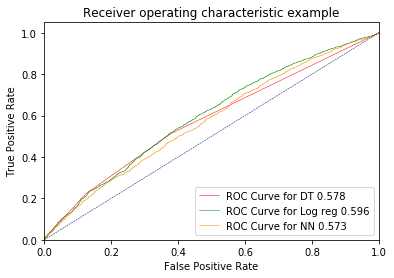

In [24]:
import matplotlib.pyplot as plt

plt.plot(fpr_dt, tpr_dt, label='ROC Curve for DT {:.3f}'.format(roc_index_dt), color='red', lw=0.5)
plt.plot(fpr_log_reg, tpr_log_reg, label='ROC Curve for Log reg {:.3f}'.format(roc_index_log_reg), color='green', lw=0.5)
plt.plot(fpr_nn, tpr_nn, label='ROC Curve for NN {:.3f}'.format(roc_index_nn), color='darkorange', lw=0.5)

# plt.plot(fpr[2], tpr[2], color='darkorange',
#          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Here, you can see the curve for different models. `LogisticRegression` again has the largest curve area compared to the other two models. Thus, all three statistics that we used collectively agreed on `LogisticRegression` being the best performing model overall.

While statistics are vital, in a real project, performance is not always the priority. Some of the other aspects used to consider a best model are:
1. Interpretability: how well can humans use the model to make decisions. Decision trees (and regressions to some extent) excel at this, while neural network not so much.
2. Speed: how well can the model train and predict on large amount of data. Again decision trees and regressions are relatively fast, while neural networks take a while to train.
3. Adaptability: in some cases, you want your model to slowly adapt to the data trend. Neural networks are great for this as they can be trained using "online training", while decision trees are not so great.

## End Notes and Next Week

This week, we learned how to build, tune and explore the structure of neural network models. We also explored dimensionality reduction techniques to reduce the size of the feature set and improve performance of our neural network model. In addition, we tried numerous statistics to compare end-to-end performance of all models we have built so far.

Next week, we will have a drop-in help session where you focus on the assignment and ask your tutor questions regarding it.